<h3>K-Nearest Neighbours (KNN) and Support Vector Machines (SVM): Diabetes Classification Dataset</h3>

<h4>Importing + Cleaning the Data</h4>

In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv("Diabetes-Classification.csv")
raw_data.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,45,Male,25.0,Normal,100,5.7,No,No,Healthy,Regular,No
1,55,Female,30.0,High,120,6.4,Yes,Yes,Poor,No,Yes
2,65,Male,35.0,High,140,7.1,Yes,Yes,Poor,No,Yes
3,75,Female,40.0,High,160,7.8,Yes,Yes,Poor,No,Yes
4,40,Male,20.0,Normal,80,5.0,No,No,Healthy,NaN,No


In [3]:
# Find out the data types:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         128 non-null    int64  
 1   Gender                      128 non-null    object 
 2   BMI                         125 non-null    float64
 3   Blood Pressure              128 non-null    object 
 4   FBS                         128 non-null    int64  
 5   HbA1c                       128 non-null    float64
 6   Family History of Diabetes  126 non-null    object 
 7   Smoking                     126 non-null    object 
 8   Diet                        126 non-null    object 
 9   Exercise                    127 non-null    object 
 10  Diagnosis                   128 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 11.1+ KB


In [4]:
# Null values?:
print(f'Rows: {raw_data.shape[0]}')
raw_data.isnull().sum()

Rows: 128


Age                           0
Gender                        0
BMI                           3
Blood Pressure                0
FBS                           0
HbA1c                         0
Family History of Diabetes    2
Smoking                       2
Diet                          2
Exercise                      1
Diagnosis                     0
dtype: int64

In [5]:
# Only 128 entries, with ~10 null values. Not a large enough dataset for imputation. Will drop these rows instead:
data = raw_data.dropna().reset_index(drop=True)
print(f'Rows: {data.shape[0]}')
data.isnull().sum()

Rows: 118


Age                           0
Gender                        0
BMI                           0
Blood Pressure                0
FBS                           0
HbA1c                         0
Family History of Diabetes    0
Smoking                       0
Diet                          0
Exercise                      0
Diagnosis                     0
dtype: int64

<h4>EDA</h4>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

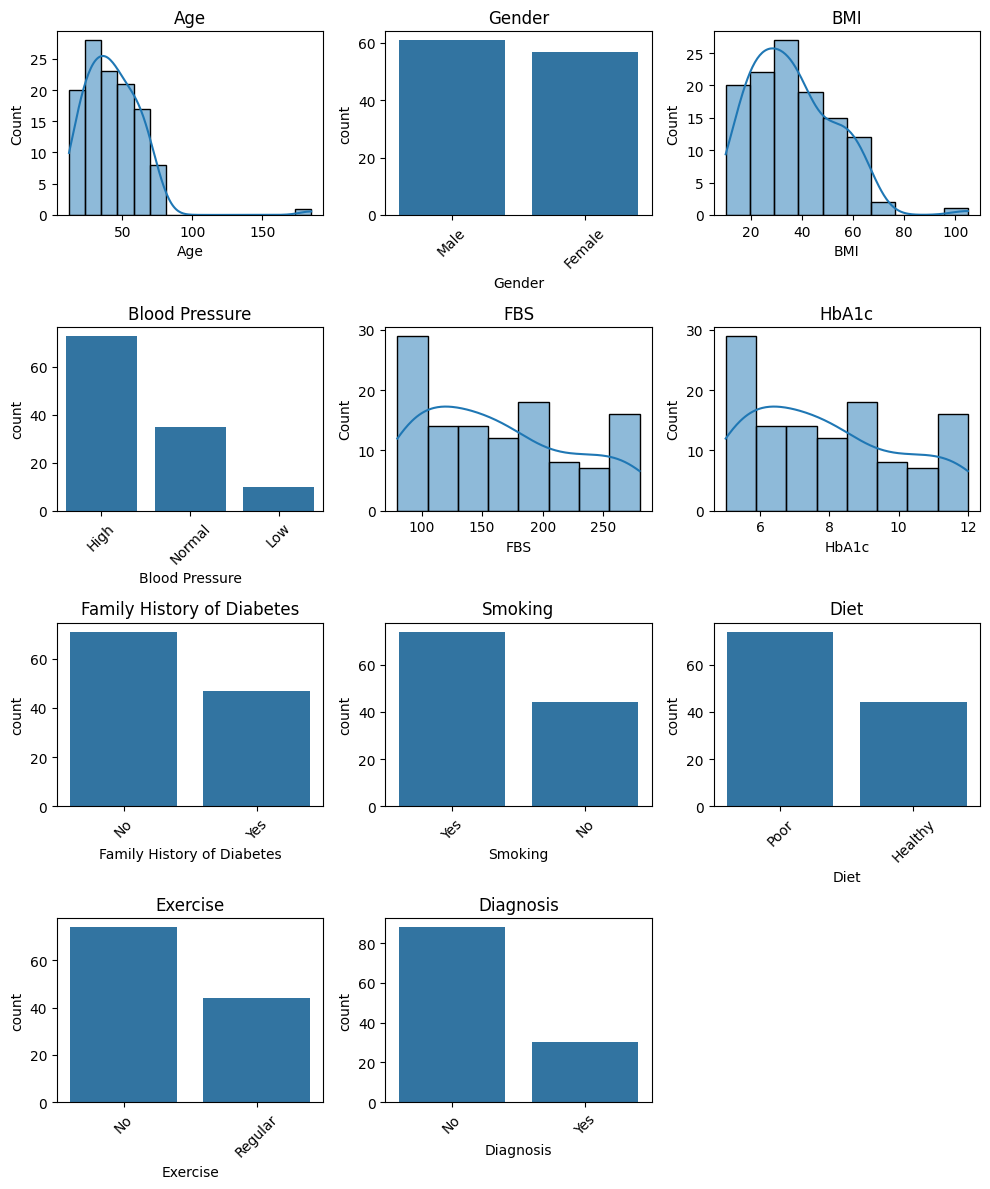

In [58]:

# Exploring the distribution of each column (histograms/barcharts)
#
# At this stage, only 4 of the 11 columns are numeric...
# Identify numeric & categorical columns

numeric_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(exclude=['number']).columns

# Total number of plots
all_cols = list(data.columns)
n_cols = 3  # number of grid columns
n_rows = int(round(len(all_cols) / n_cols))

plt.figure(figsize=(10, n_rows * 3))

for i, col in enumerate(all_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    if col in numeric_cols:
        # Numeric -> histogram
        sns.histplot(data[col], kde=True)
    else:
        # Categorical -> count plot
        sns.countplot(x=data[col], order=data[col].value_counts().index)
        plt.xticks(rotation=45)
    
    plt.title(col)

plt.tight_layout()
plt.show()

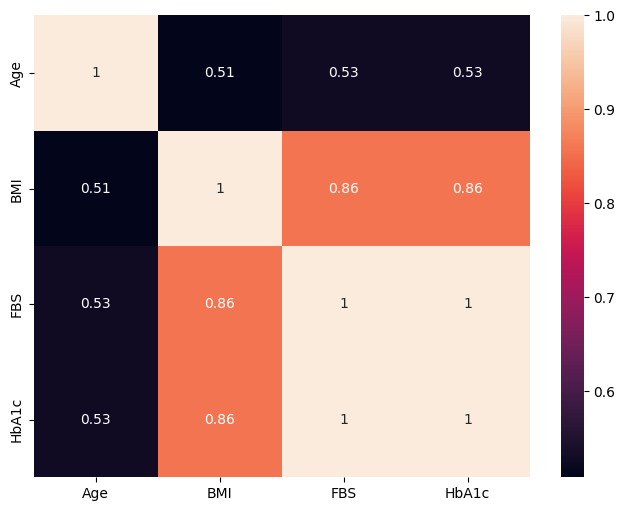

In [8]:
# Correlation heatmap of the numerical data:

plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True)
plt.show()

In [9]:
# HbA1c and FBS is highly positively correlated with BMI.
# HbA1c and FBS are perfectly positively correlated.

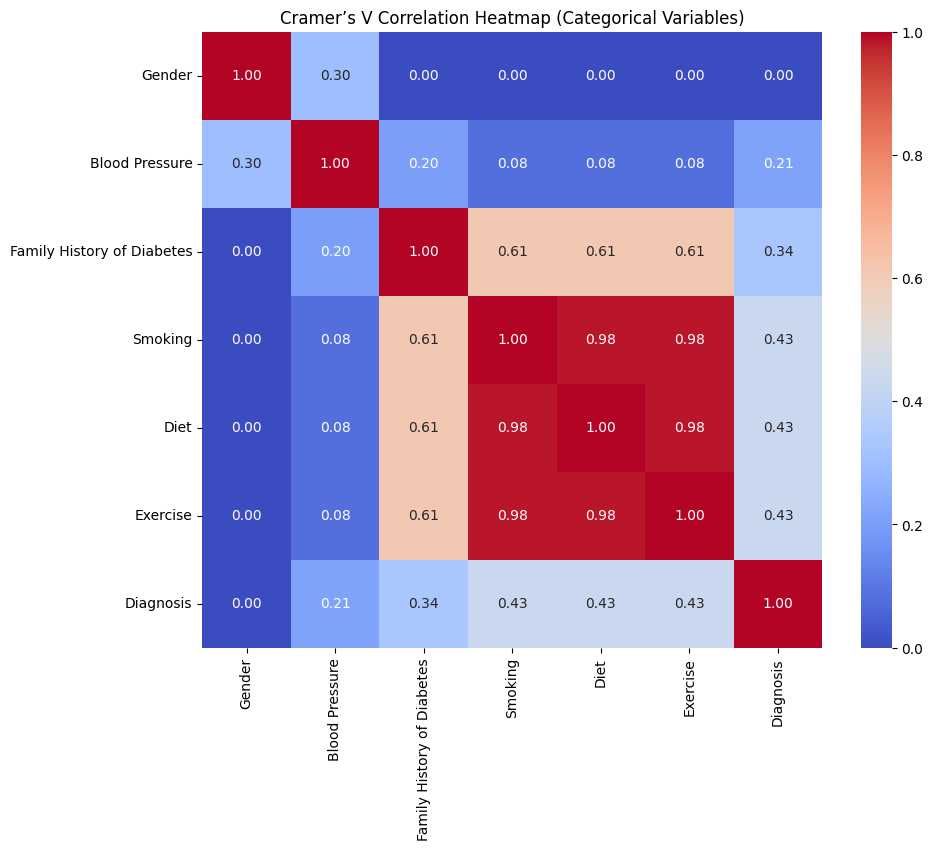

In [10]:
# Cramer’s V function + heatmap: correlation metric for categorical data:

# Cramér’s V is a measure of association between two categorical variables based on chi-squared.

import scipy.stats as ss

# Select categorical columns
cats = data.select_dtypes(exclude='number')

# Cramer's V function
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

# Create the matrix
cramers_matrix = pd.DataFrame(
    np.zeros((len(cats.columns), len(cats.columns))),
    columns=cats.columns,
    index=cats.columns
)

for c1 in cats.columns:
    for c2 in cats.columns:
        cramers_matrix.loc[c1, c2] = cramers_v(cats[c1], cats[c2])

np.fill_diagonal(cramers_matrix.values, 1.0)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cramer’s V Correlation Heatmap (Categorical Variables)")
plt.show()

In [11]:
# The only 'significant' correlations we are seeing are the the 'family history of diabetes' with 'exercise', 'diet' and 'smoking'.
# Diagnosis shows moderate correlation with 'smoking', 'diet' and 'exercise' (I guess this makes sense from a medical point of view!)

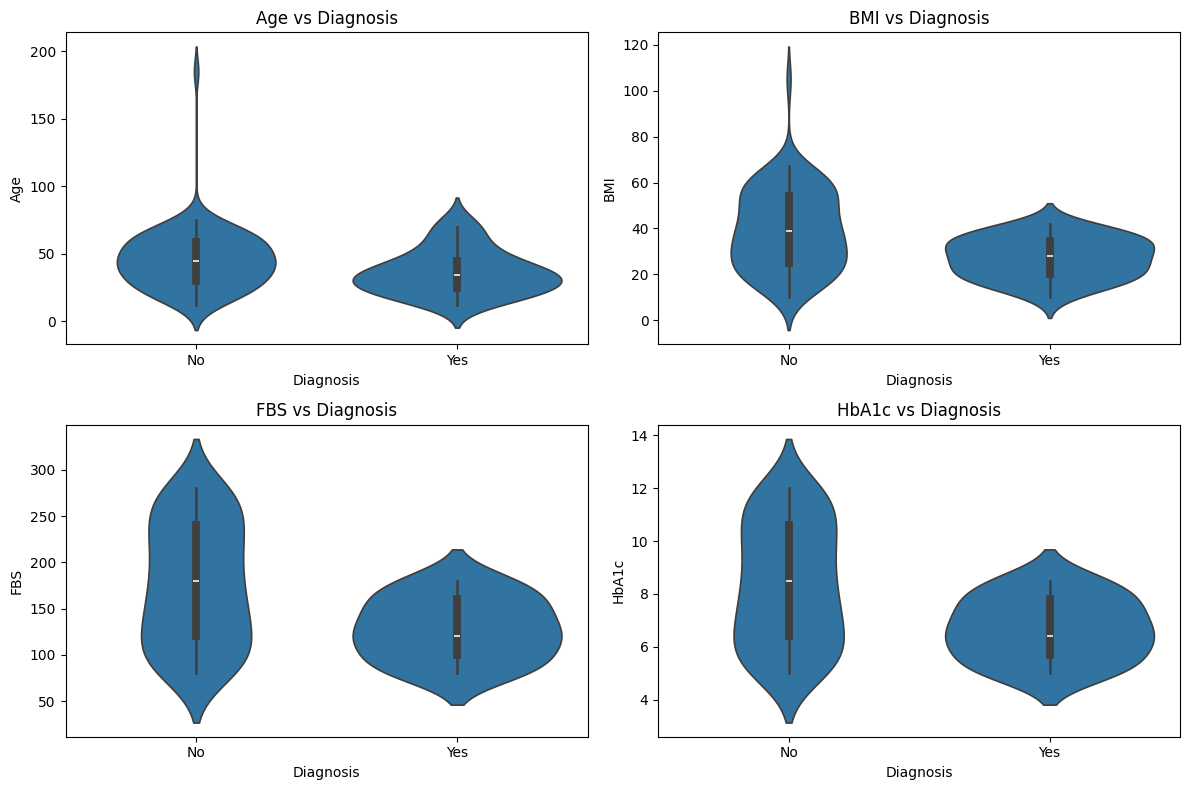

In [12]:
# Visualisation of numeric data distribution vs diagnosis outcome:

numeric_cols = data.select_dtypes(include='number').columns
target = "Diagnosis"

n_cols = 2
n_rows = int(round(len(numeric_cols) / n_cols))

plt.figure(figsize=(12, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=data, x=target, y=col)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()

plt.show()

In [13]:
# Larger FBS and HbA1c values are associated with lower liklehood of negative diagnosis.

In [14]:
data['Age'].max()

185

In [15]:
# Just to confirm the violin plot, there appears to be ages close to 200!
# Extreme BMIs and ages are assocaited with a negative diagnosis...
# Outliers?

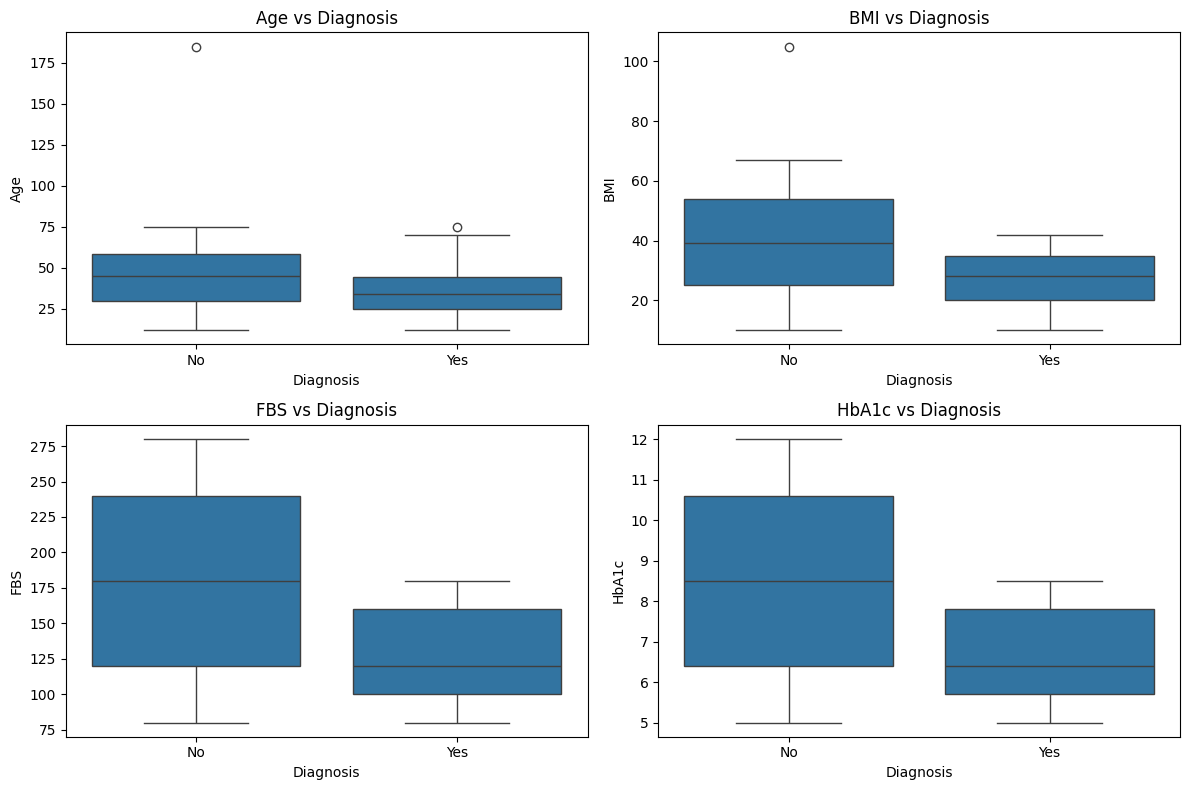

In [16]:
# Check for outlliers with boxplots:
# Use same columns as above violin plots:

plt.figure(figsize=(12, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=data, x=target, y=col)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()

plt.show()

In [17]:
# Yes: there appears to be outliers for 'age' and 'BMI'

<h4>Data Preparation: Encoding of Categorical Data</h4>

In [18]:
# One-Hot Encoding
# Creates a separate binary column for each category (e.g., Male → 1/0, Female → 1/0). 
# This is the safest and most widely used method for nominal data, as it avoids imposing any artificial order. 
# Works well with distance-based models like KNN and margin-based models like SVM.

# Dummy Encoding
# A variant of one-hot encoding where one category is dropped (k–1 columns).
# This prevents multicollinearity and is commonly used for linear models, though functionally equivalent to one-hot encoding for most classifiers.

# Target Encoding
# Replaces each category with the mean of the target variable for that category. 
# Useful when a feature has many categories (high cardinality), but care must be taken to avoid target leakage by using cross-validation during encoding.

# Embedding Encoding
# Learns dense vector representations of categories, typically in neural network models. 
# Powerful for high-cardinality features but usually unnecessary for algorithms like SVM and KNN.

# Avoid Label/Ordinal Encoding
# Assigning integers to categories introduces an artificial ranking and distance between them (e.g., Red=0, Green=1, Blue=2). 
# This is not appropriate for nominal variables and can distort results for SVM and KNN, which are sensitive to feature scales and distances.

In [19]:
data.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,45,Male,25.0,Normal,100,5.7,No,No,Healthy,Regular,No
1,55,Female,30.0,High,120,6.4,Yes,Yes,Poor,No,Yes
2,65,Male,35.0,High,140,7.1,Yes,Yes,Poor,No,Yes
3,75,Female,40.0,High,160,7.8,Yes,Yes,Poor,No,Yes
4,50,Female,25.0,Normal,100,5.7,No,No,Healthy,Regular,No


In [20]:
# Will use One-Hot encoding here as most of categorical columns are nominal (as opposed to ordinal).

# One could argue that 'Blood Pressure' is ordinal: Low -> Normal -> High. However, ordinal encoding techniques may introduce artificial distance between the different values. 
# Will still use One-Hot encoding for all the categorical columns (bar diagnosis, we will just use Label encoding for this 0 = No, 1 = Yes)

from sklearn.preprocessing import LabelEncoder

# Label encode the target (y) column
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data["Diagnosis"])   # Yes/No → 1/0

# Identify other categorical columns (excluding the target)
categorical_cols = data.select_dtypes(exclude="number").columns.drop("Diagnosis", errors="ignore")

# One-hot encode the non-target categorical columns
oh_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

# Combine the one-hot encoded features with the label-encoded target
encoded_data = oh_encoded.drop('Diagnosis', axis=1).copy()
encoded_data['Diagnosis'] = label_encoded

encoded_data.head()

,Age,BMI,FBS,HbA1c,Gender_Female,Gender_Male,Blood Pressure_High,Blood Pressure_Low,Blood Pressure_Normal,Family History of Diabetes_No,Family History of Diabetes_Yes,Smoking_No,Smoking_Yes,Diet_Healthy,Diet_Poor,Exercise_No,Exercise_Regular,Diagnosis
0,45,25.0,100,5.7,False,True,False,False,True,True,False,True,False,True,False,False,True,0
1,55,30.0,120,6.4,True,False,True,False,False,False,True,False,True,False,True,True,False,1
2,65,35.0,140,7.1,False,True,True,False,False,False,True,False,True,False,True,True,False,1
3,75,40.0,160,7.8,True,False,True,False,False,False,True,False,True,False,True,True,False,1
4,50,25.0,100,5.7,True,False,False,False,True,True,False,True,False,True,False,False,True,0


In [21]:
# Convert boolean columns to integers (0/1) to be compatiable with ML models.
encoded_data = encoded_data.astype({col: int for col in encoded_data.select_dtypes(include='bool').columns})
encoded_data.head()

,Age,BMI,FBS,HbA1c,Gender_Female,Gender_Male,Blood Pressure_High,Blood Pressure_Low,Blood Pressure_Normal,Family History of Diabetes_No,Family History of Diabetes_Yes,Smoking_No,Smoking_Yes,Diet_Healthy,Diet_Poor,Exercise_No,Exercise_Regular,Diagnosis
0,45,25.0,100,5.7,0,1,0,0,1,1,0,1,0,1,0,0,1,0
1,55,30.0,120,6.4,1,0,1,0,0,0,1,0,1,0,1,1,0,1
2,65,35.0,140,7.1,0,1,1,0,0,0,1,0,1,0,1,1,0,1
3,75,40.0,160,7.8,1,0,1,0,0,0,1,0,1,0,1,1,0,1
4,50,25.0,100,5.7,1,0,0,0,1,1,0,1,0,1,0,0,1,0


<h4>Feature Selection

In [22]:
X = encoded_data.drop(columns=['Diagnosis'],axis=1)
y = encoded_data['Diagnosis']

In [23]:
# 1) Mutual Information: Measures how much knowing the value of a feature reduces uncertainty about the target. It captures both linear and non-linear relationships, 
# making it useful for mixed numeric/categorical datasets.

from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, discrete_features='auto')
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi_series

Exercise_No                       0.217373
Diet_Poor                         0.207678
Exercise_Regular                  0.197369
Diet_Healthy                      0.168984
Smoking_Yes                       0.154986
HbA1c                             0.128197
Smoking_No                        0.090908
Family History of Diabetes_No     0.071416
FBS                               0.065581
Family History of Diabetes_Yes    0.064378
Blood Pressure_High               0.038048
Blood Pressure_Low                0.027651
BMI                               0.025607
Gender_Male                       0.001871
Gender_Female                     0.000226
Age                               0.000000
Blood Pressure_Normal             0.000000
dtype: float64

In [24]:
# 2) Chi-sqaure: Evaluates whether a feature’s categorical values are statistically associated with the target by comparing observed vs expected frequencies. 
# Higher chi2 scores indicate stronger dependence between feature and class.

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

scaler = MinMaxScaler() #Good practice to scale features for chi2 testing
X_scaled = scaler.fit_transform(X)
chi_vals, chi_p = chi2(X_scaled, y)
chi_series = pd.Series(chi_vals, index=X.columns).sort_values(ascending=False)
chi_series

Exercise_Regular                  15.000000
Diet_Healthy                      15.000000
Smoking_No                        15.000000
Family History of Diabetes_Yes     8.987234
Exercise_No                        8.918919
Diet_Poor                          8.918919
Smoking_Yes                        8.918919
Family History of Diabetes_No      5.949296
Blood Pressure_Low                 3.185606
FBS                                3.043706
HbA1c                              3.043706
Blood Pressure_High                1.501889
BMI                                1.304334
Blood Pressure_Normal              0.665628
Age                                0.325090
Gender_Female                      0.023923
Gender_Male                        0.022355
dtype: float64

In [25]:
#Higher chi2 scores indicate stronger dependence between feature and class.

In [26]:
# 3) Recursive Feature Elimination (RFE): Iteratively trains a model and removes the least important features at each step until only the most informative subset remains. 
# It uses the model’s learned weights to identify which features contribute most to prediction.


from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel='linear')
rfe = RFE(svc, n_features_to_select=5)
rfe.fit(X, y)
rfe_selected = X.columns[rfe.support_]
rfe_selected

Index(['Family History of Diabetes_No', 'Family History of Diabetes_Yes',
       'Diet_Poor', 'Exercise_No', 'Exercise_Regular'],
      dtype='object')

In [27]:
# 4) L1-regularised Linear SVM:

from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=0.1, penalty='l1', dual=False, max_iter=5000)
lsvc.fit(X, y)

# Get feature coefficients and select top 5 by absolute value
feature_importance = pd.Series(np.abs(lsvc.coef_.ravel()), index=X.columns).sort_values(ascending=False)
l1_selected = feature_importance.head(5).index # return top 5 features

l1_selected

Index(['Family History of Diabetes_Yes', 'Family History of Diabetes_No',
       'Diet_Healthy', 'Smoking_Yes', 'Smoking_No'],
      dtype='object')

In [28]:
# 5) Random Forest Importance: Uses an ensemble of decision trees to estimate how much each feature reduces impurity across all splits in the forest. 
# Features that consistently improve node purity receive higher importance scores.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X, y)
rf_series = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_series

Family History of Diabetes_Yes    0.268405
Family History of Diabetes_No     0.210779
Smoking_Yes                       0.071160
BMI                               0.058606
FBS                               0.056451
Age                               0.055188
HbA1c                             0.051925
Exercise_No                       0.046634
Diet_Healthy                      0.041518
Diet_Poor                         0.039031
Smoking_No                        0.038182
Exercise_Regular                  0.031759
Blood Pressure_Normal             0.010646
Blood Pressure_High               0.009694
Gender_Male                       0.005202
Gender_Female                     0.003139
Blood Pressure_Low                0.001682
dtype: float64

In [29]:
# 6) K-best feature selection: ranks all features using a chosen statistical scoring method (such as mutual information or chi-square) 
# and selects only the top K highest-scoring predictors.


from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
x_selected=selector.fit_transform(X,y)
kbest_features=X.columns[selector.get_support()]
kbest_features

Index(['Smoking_Yes', 'Diet_Healthy', 'Diet_Poor', 'Exercise_No',
       'Exercise_Regular'],
      dtype='object')

In [30]:
# Will train using 5 most important features for now:

no_features = 5 # The top n number of features to be added to 'selected_features'

features = (mi_series.nlargest(5), chi_series.nlargest(5), rfe_selected, l1_selected, rf_series.nlargest(5), kbest_features)

# Find the most commonly mentioned features across all selection methods
# Flatten all feature names from the different selection methods
all_features = []
for feature_set in features:
    if hasattr(feature_set, 'index'):  # For pandas Series
        all_features.extend(feature_set.index.tolist())
    else:  # For pandas Index objects
        all_features.extend(feature_set.tolist())

# Count occurrences of each feature
from collections import Counter
feature_counts = Counter(all_features)

selected_features = [feature for feature, count in feature_counts.most_common(no_features)]
selected_features

# May be interesting to see how model performance is affected by the number of important features are used.


['Exercise_No',
 'Exercise_Regular',
 'Diet_Healthy',
 'Smoking_Yes',
 'Family History of Diabetes_Yes']

<h4>KNN Models

In [31]:
# Now have the selected features to train on.
# Filter to include only selected features for X, then generate training + testing datasets:
selected_features

['Exercise_No',
 'Exercise_Regular',
 'Diet_Healthy',
 'Smoking_Yes',
 'Family History of Diabetes_Yes']

In [32]:
X5 = encoded_data[selected_features]
y = encoded_data['Diagnosis']
X5.head()

,Exercise_No,Exercise_Regular,Diet_Healthy,Smoking_Yes,Family History of Diabetes_Yes
0,0,1,1,0,0
1,1,0,0,1,1
2,1,0,0,1,1
3,1,0,0,1,1
4,0,1,1,0,0


In [33]:
# Not dealing with 'numerical' data, only 'categorical' at this point, so won't be doing standard scaling here. Go straight to splitting of selected features dataset:

from sklearn.model_selection import train_test_split

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(X5,y,test_size=0.3,random_state=13)


In [34]:
# Train a KNN model based on the selected features (5):

from sklearn.neighbors import KNeighborsClassifier

knn_s = KNeighborsClassifier(n_neighbors=5)

knn_s.fit(x_train_s,y_train_s)
y_pred_s_knn = knn_s.predict(x_test_s)

In [35]:
# Train a KNN model based on all features. Will do standard scaling of the continusous numerical features:

from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

number_columns = ['Age','BMI','FBS','HbA1c']

X_af = encoded_data.drop('Diagnosis',axis=1) # All predictor columns from the original dataset (post encoding)
X_af_scaled_columns = pd.DataFrame(robust_scaler.fit_transform(X[number_columns]), columns=['Age','BMI','FBS','HbA1c']) #Scale the continuous data columns only.
X_af[number_columns] = X_af_scaled_columns

x_train_af, x_test_af, y_train_af, y_test_af = train_test_split(X_af,y,test_size=0.3,random_state=13) #Split whole dataset (non selective)
knn_af= KNeighborsClassifier(n_neighbors=5)


knn_af.fit(x_train_af,y_train_af)
y_pred_af_knn = knn_af.predict(x_test_af)

<h5>Model Performance Evaluation: KNN

In [36]:
# 1) Classification Report:

from sklearn.metrics import classification_report

print("Selected Features (5) KNN Model Performance")
print(classification_report(y_test_s,y_pred_s_knn))

print("All Features KNN Model Performance")
print(classification_report(y_test_af,y_pred_af_knn))

Selected Features (5) KNN Model Performance
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.91      0.95        11

    accuracy                           0.97        36
   macro avg       0.98      0.95      0.97        36
weighted avg       0.97      0.97      0.97        36

All Features KNN Model Performance
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        25
           1       1.00      0.82      0.90        11

    accuracy                           0.94        36
   macro avg       0.96      0.91      0.93        36
weighted avg       0.95      0.94      0.94        36



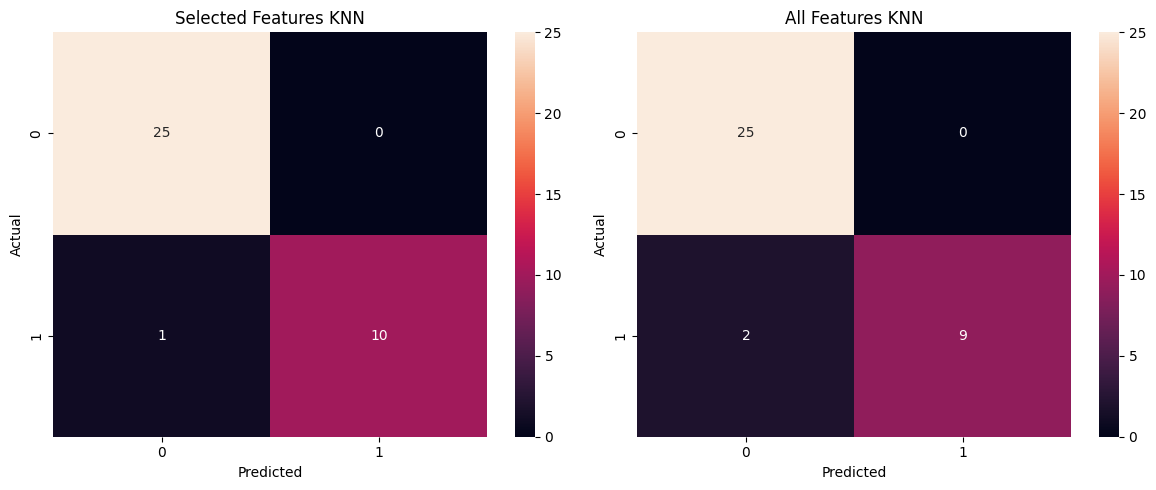

In [37]:
# 2) Confusion Matrix:

from sklearn.metrics import confusion_matrix

# Create subplots for both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Selected features confusion matrix
cm_s_knn = confusion_matrix(y_test_s, y_pred_s_knn)
sns.heatmap(cm_s_knn, annot=True, ax=axes[0], fmt='d')
axes[0].set_title('Selected Features KNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# All features confusion matrix
cm_af_knn = confusion_matrix(y_test_af, y_pred_af_knn)
sns.heatmap(cm_af_knn, annot=True, ax=axes[1], fmt='d')
axes[1].set_title('All Features KNN')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

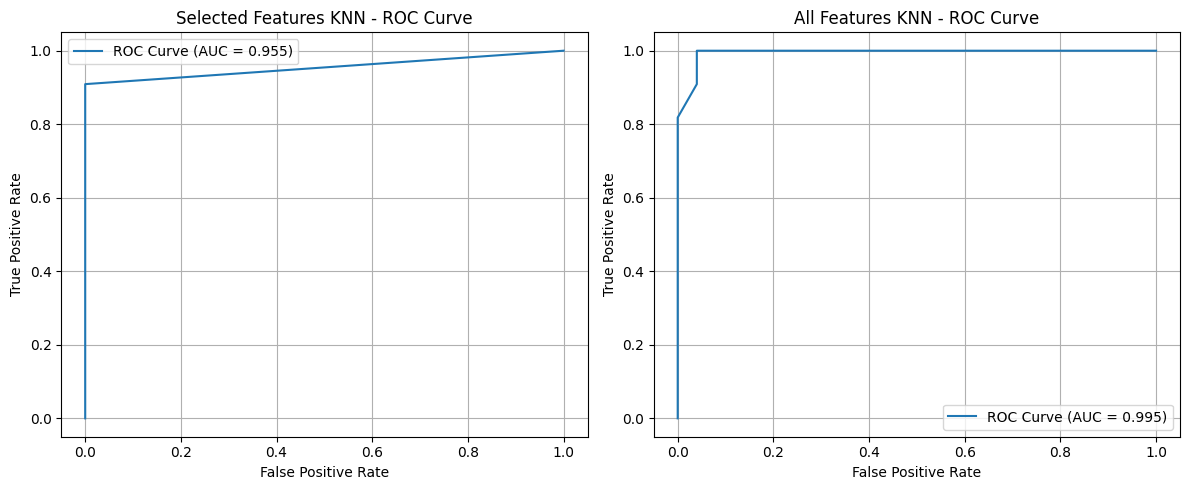

Selected Features KNN AUC: 0.955
All Features KNN AUC: 0.995


In [38]:
# 3) ROC Curve + AUC:

from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for ROC curve
y_prob_s_knn = knn_s.predict_proba(x_test_s)[:, 1]
y_prob_af_knn = knn_af.predict_proba(x_test_af)[:, 1]

# Calculate ROC curve data
fpr_s_knn, tpr_s_knn, _ = roc_curve(y_test_s, y_prob_s_knn)
fpr_af_knn, tpr_af_knn, _ = roc_curve(y_test_af, y_prob_af_knn)

# Calculate AUC ()
auc_s_knn = auc(fpr_s_knn, tpr_s_knn)
auc_af_knn = auc(fpr_af_knn, tpr_af_knn)

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Selected features ROC
axes[0].plot(fpr_s_knn, tpr_s_knn, label=f'ROC Curve (AUC = {auc_s_knn:.3f})')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Selected Features KNN - ROC Curve')
axes[0].legend()
axes[0].grid(True)

# All features ROC
axes[1].plot(fpr_af_knn, tpr_af_knn, label=f'ROC Curve (AUC = {auc_af_knn:.3f})')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('All Features KNN - ROC Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Selected Features KNN AUC: {auc_s_knn:.3f}")
print(f"All Features KNN AUC: {auc_af_knn:.3f}")



In [39]:
# 4) Matthews Correlation Coefficient (MCC):

# A balanced metric using all four confusion matrix terms. Values range from −1 (worst) to +1 (perfect).

from sklearn.metrics import matthews_corrcoef

mcc_s_knn = matthews_corrcoef(y_test_s, y_pred_s_knn)
mcc_af_knn = matthews_corrcoef(y_test_af, y_pred_af_knn)

print(f"Selected Features KNN MCC: {mcc_s_knn:.3f}")
print(f"All Features KNN MCC: {mcc_af_knn:.3f}")

Selected Features KNN MCC: 0.935
All Features KNN MCC: 0.870


<h4>SVM Models

In [40]:
# Create SVM models on the same selected features and all-features datasets
# Data is already encoded, scaled + split:

# Selected features: x_train_s, x_test_s, y_train_s, y_test_s
# All features: x_train_af, x_test_af, y_train_af, y_test_af

from sklearn.svm import SVC

svm_s=SVC(kernel='rbf', probability=True,random_state=13)
svm_af=SVC(kernel='rbf', probability=True,random_state=13)

svm_s.fit(x_train_s,y_train_s)
svm_af.fit(x_train_af,y_train_af)

y_pred_s_svm = svm_s.predict(x_test_s)
y_pred_af_svm = svm_af.predict(x_test_af)

<h5>Model Performance Evaluation: KNN

In [41]:
# Model Performance Evaluation: SVM

# 1) Classification Report:
print("Selected Features (5) SVM Model Performance")
print(classification_report(y_test_s, y_pred_s_svm))

print("All Features SVM Model Performance")
print(classification_report(y_test_af, y_pred_af_svm))

Selected Features (5) SVM Model Performance
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.91      0.95        11

    accuracy                           0.97        36
   macro avg       0.98      0.95      0.97        36
weighted avg       0.97      0.97      0.97        36

All Features SVM Model Performance
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.91      0.95        11

    accuracy                           0.97        36
   macro avg       0.98      0.95      0.97        36
weighted avg       0.97      0.97      0.97        36



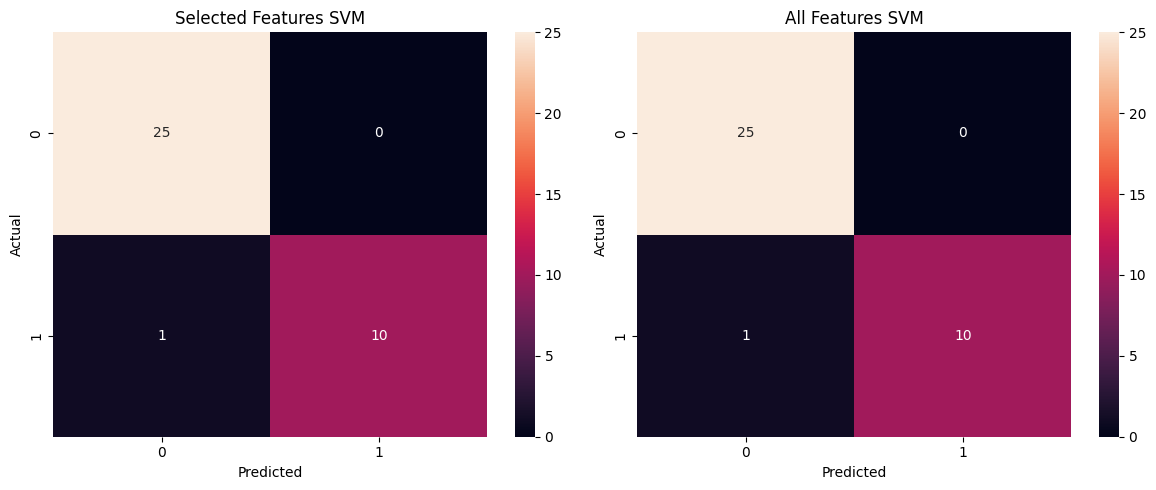

In [42]:
# 2) Confusion Matrix:

# Create subplots for both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Selected features confusion matrix
cm_s_svm = confusion_matrix(y_test_s, y_pred_s_svm)
sns.heatmap(cm_s_svm, annot=True, ax=axes[0], fmt='d')
axes[0].set_title('Selected Features SVM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# All features confusion matrix
cm_af_svm = confusion_matrix(y_test_af, y_pred_af_svm)
sns.heatmap(cm_af_svm, annot=True, ax=axes[1], fmt='d')
axes[1].set_title('All Features SVM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

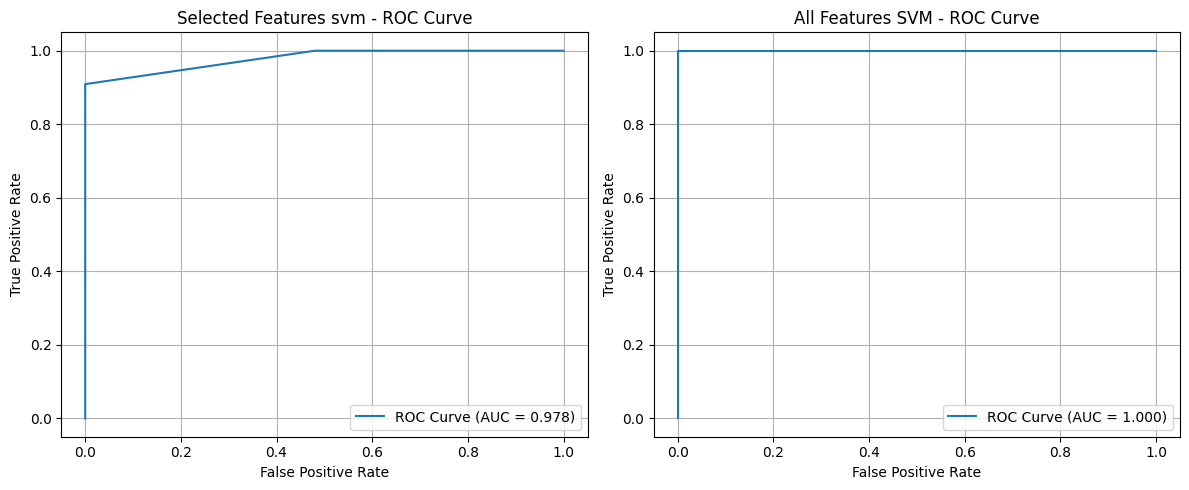

Selected Features SVM AUC: 0.978
All Features SVM AUC: 1.000


In [43]:
# 3) ROC Curve + AUC:

# Get prediction probabilities for ROC curve
y_prob_s_svm = svm_s.predict_proba(x_test_s)[:, 1]
y_prob_af_svm = svm_af.predict_proba(x_test_af)[:, 1]

# Calculate ROC curve data
fpr_s_svm, tpr_s_svm, _ = roc_curve(y_test_s, y_prob_s_svm)
fpr_af_svm, tpr_af_svm, _ = roc_curve(y_test_af, y_prob_af_svm)

# Calculate AUC ()
auc_s_svm = auc(fpr_s_svm, tpr_s_svm)
auc_af_svm = auc(fpr_af_svm, tpr_af_svm)

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Selected features ROC
axes[0].plot(fpr_s_svm, tpr_s_svm, label=f'ROC Curve (AUC = {auc_s_svm:.3f})')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Selected Features svm - ROC Curve')
axes[0].legend()
axes[0].grid(True)

# All features ROC
axes[1].plot(fpr_af_svm, tpr_af_svm, label=f'ROC Curve (AUC = {auc_af_svm:.3f})')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('All Features SVM - ROC Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Selected Features SVM AUC: {auc_s_svm:.3f}")
print(f"All Features SVM AUC: {auc_af_svm:.3f}")

In [44]:
# 4) Matthews Correlation Coefficient (MCC):

mcc_s_svm = matthews_corrcoef(y_test_s, y_pred_s_svm)
mcc_af_svm = matthews_corrcoef(y_test_af, y_pred_af_svm)

print(f"Selected Features SVM MCC: {mcc_s_svm:.3f}")
print(f"All Features SVM MCC: {mcc_af_svm:.3f}")

Selected Features SVM MCC: 0.935
All Features SVM MCC: 0.935


Performance Summary:

/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/2274168886.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_performance_df['Model'], rotation=45, ha='right')
/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/2274168886.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_performance_df['Model'], rotation=45, ha='right')
/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/2274168886.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_performance_df['Model'], rotation=45, ha='right')
/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/2274168886.py:57: UserWarning: set_ticklabels() should only be used wit

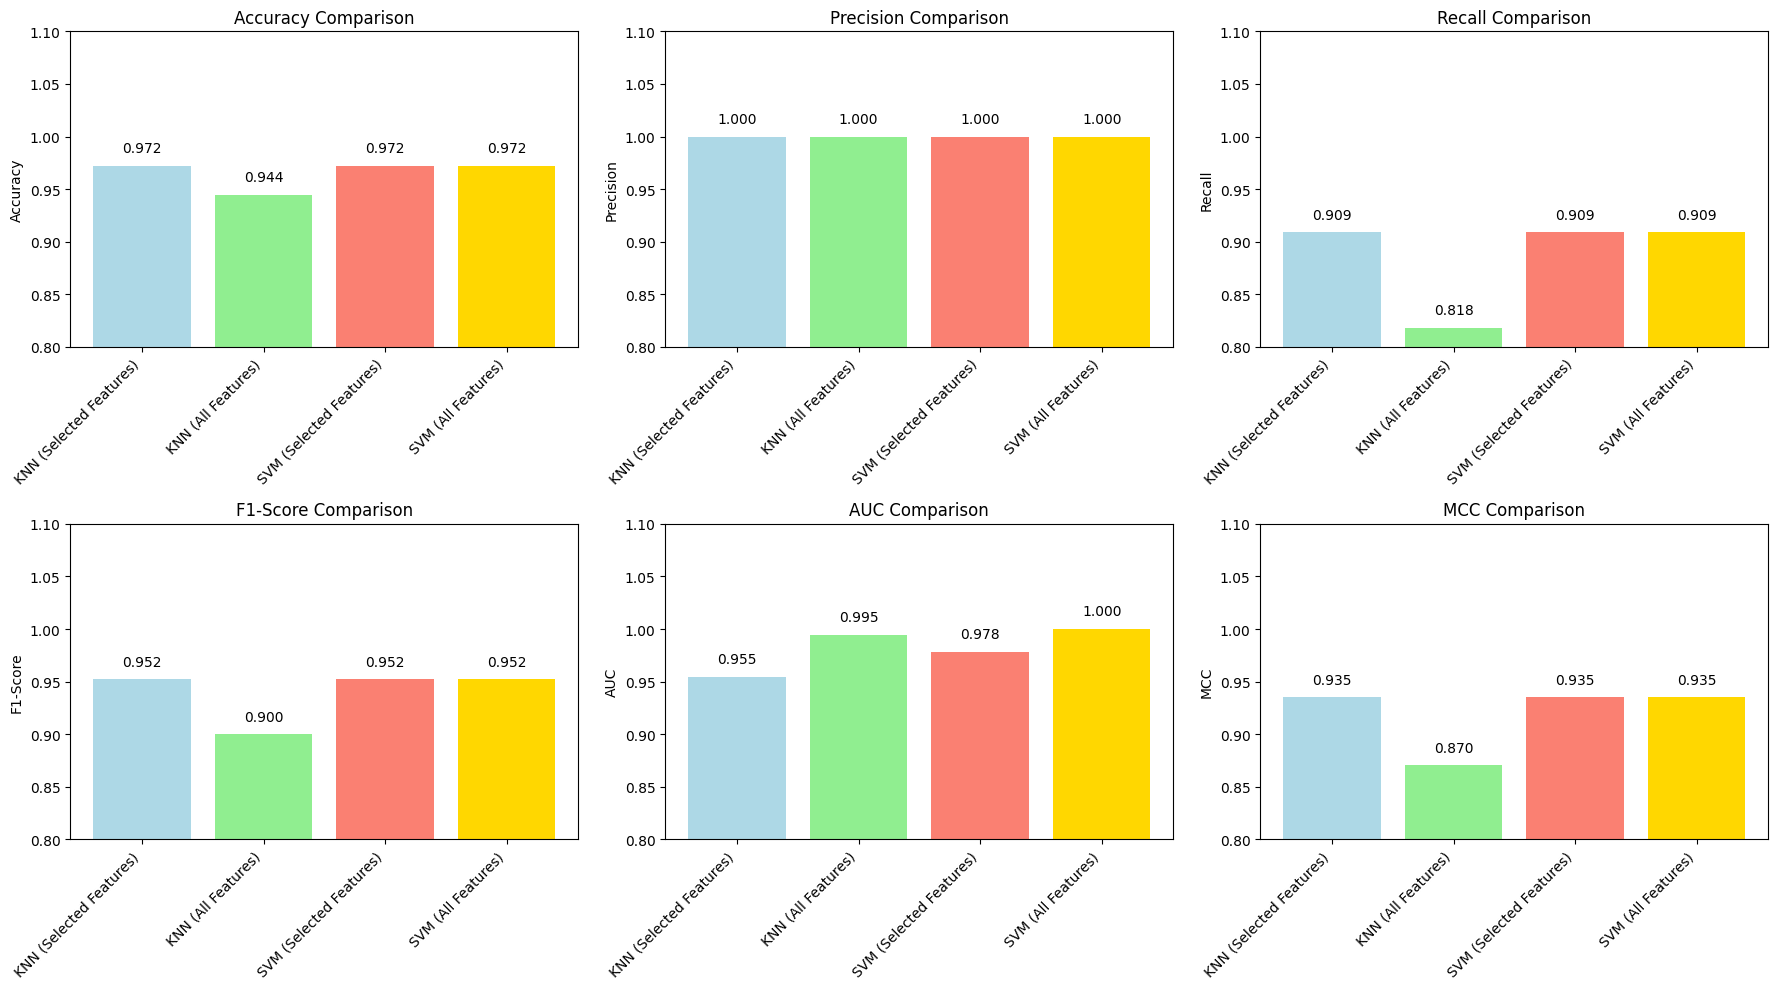

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

performance_data = {
    'Model': ['KNN (Selected Features)', 'KNN (All Features)', 'SVM (Selected Features)', 'SVM (All Features)'],
    'AUC': [auc_s_knn, auc_af_knn, auc_s_svm, auc_af_svm],
    'MCC': [mcc_s_knn, mcc_af_knn, mcc_s_svm, mcc_af_svm]
}

# Create DataFrame
performance_df = pd.DataFrame(performance_data)

additional_metrics = []
for y_true, y_pred, model_name in [
    (y_test_s, y_pred_s_knn, 'KNN (Selected Features)'),
    (y_test_af, y_pred_af_knn, 'KNN (All Features)'),
    (y_test_s, y_pred_s_svm, 'SVM (Selected Features)'),
    (y_test_af, y_pred_af_svm, 'SVM (All Features)')
]:
    additional_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    })

additional_df = pd.DataFrame(additional_metrics)

# Merge the dataframes
final_performance_df = pd.merge(performance_df, additional_df, on='Model')

# Create a visual comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'MCC']
colors = ['lightblue', 'lightgreen', 'salmon', 'gold']

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    bars = ax.bar(final_performance_df['Model'], final_performance_df[metric], color=colors)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_ylim(0.8, 1.1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(final_performance_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

<h4>Taking SVM (All features) and carrying out LabelEncoding instead of OneHotEncoding

In [46]:
# Data before the encoding happened in the previous work:

X = data.drop(['Diagnosis'],axis=1)
y = data['Diagnosis']
X.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise
0,45,Male,25.0,Normal,100,5.7,No,No,Healthy,Regular
1,55,Female,30.0,High,120,6.4,Yes,Yes,Poor,No
2,65,Male,35.0,High,140,7.1,Yes,Yes,Poor,No
3,75,Female,40.0,High,160,7.8,Yes,Yes,Poor,No
4,50,Female,25.0,Normal,100,5.7,No,No,Healthy,Regular


In [47]:
X_string_columns = X.select_dtypes(include='object').columns

In [48]:
#Encoder
label_encoder = LabelEncoder()
# Apply label encoding to each string column separately
X_lencoded = X.copy()
for col in X_string_columns:
    X_lencoded[col] = label_encoder.fit_transform(X[col])

y_lencoded = label_encoder.fit_transform(y)


In [49]:
X_lencoded.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise
0,45,1,25.0,2,100,5.7,0,0,0,1
1,55,0,30.0,0,120,6.4,1,1,1,0
2,65,1,35.0,0,140,7.1,1,1,1,0
3,75,0,40.0,0,160,7.8,1,1,1,0
4,50,0,25.0,2,100,5.7,0,0,0,1


In [50]:
y_lencoded

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1])

In [51]:
# Apply scaling to the Age, BMI, FBS and HbA1c columns

X_lencoded_scaled = X_lencoded.copy()
X_number_columns = ['Age', 'BMI', 'FBS', 'HbA1c']

for col in X_number_columns:
    X_lencoded_scaled[col] = robust_scaler.fit_transform(X_lencoded[[col]])

In [52]:
X_lencoded_scaled

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise
0,0.175439,1,-0.367347,2,-0.6,-0.6,0,0,0,1
1,0.526316,0,-0.163265,0,-0.4,-0.4,1,1,1,0
2,0.877193,1,0.040816,0,-0.2,-0.2,1,1,1,0
3,1.228070,0,0.244898,0,0.0,0.0,1,1,1,0
4,0.350877,0,-0.367347,2,-0.6,-0.6,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
113,-0.807018,0,-0.775510,2,-0.6,-0.6,0,1,1,0
114,-0.631579,1,-0.612245,2,-0.4,-0.4,0,1,1,0
115,-0.456140,0,-0.408163,0,-0.2,-0.2,0,1,1,0
116,-0.280702,1,-0.204082,0,0.0,0.0,0,1,1,0


In [53]:
# Splitting the data:
x_train_le, x_test_le, y_train_le, y_test_le = train_test_split(X_lencoded_scaled,y_lencoded,test_size=0.3,random_state=13) #Split whole dataset

In [54]:
# Train a new SVM model + make predictions:
svm_le=SVC(kernel='rbf', probability=True,random_state=13)
svm_le.fit(x_train_le,y_train_le)
y_pred_le = svm_le.predict(x_test_le)

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, matthews_corrcoef

# Calculate performance metrics for the SVM Label Encoded model

# Calculate all 6 performance metrics for SVM Label Encoded model
svm_le_accuracy = accuracy_score(y_test_le, y_pred_le)
svm_le_precision = precision_score(y_test_le, y_pred_le)
svm_le_recall = recall_score(y_test_le, y_pred_le)
svm_le_f1 = f1_score(y_test_le, y_pred_le)
svm_le_mcc = matthews_corrcoef(y_test_le, y_pred_le)

# Get prediction probabilities and calculate AUC
y_prob_le_svm = svm_le.predict_proba(x_test_le)[:, 1]
fpr_le_svm, tpr_le_svm, _ = roc_curve(y_test_le, y_prob_le_svm)
svm_le_auc = auc(fpr_le_svm, tpr_le_svm)

/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/3652208314.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_performance_df_updated['Model'], rotation=45, ha='right')
/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/3652208314.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_performance_df_updated['Model'], rotation=45, ha='right')
/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/3652208314.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_performance_df_updated['Model'], rotation=45, ha='right')
/var/folders/bw/y81spjm11x78s7y1l9x977qc0000gn/T/ipykernel_32199/3652208314.py:59: UserWarning: set_ticklabels()

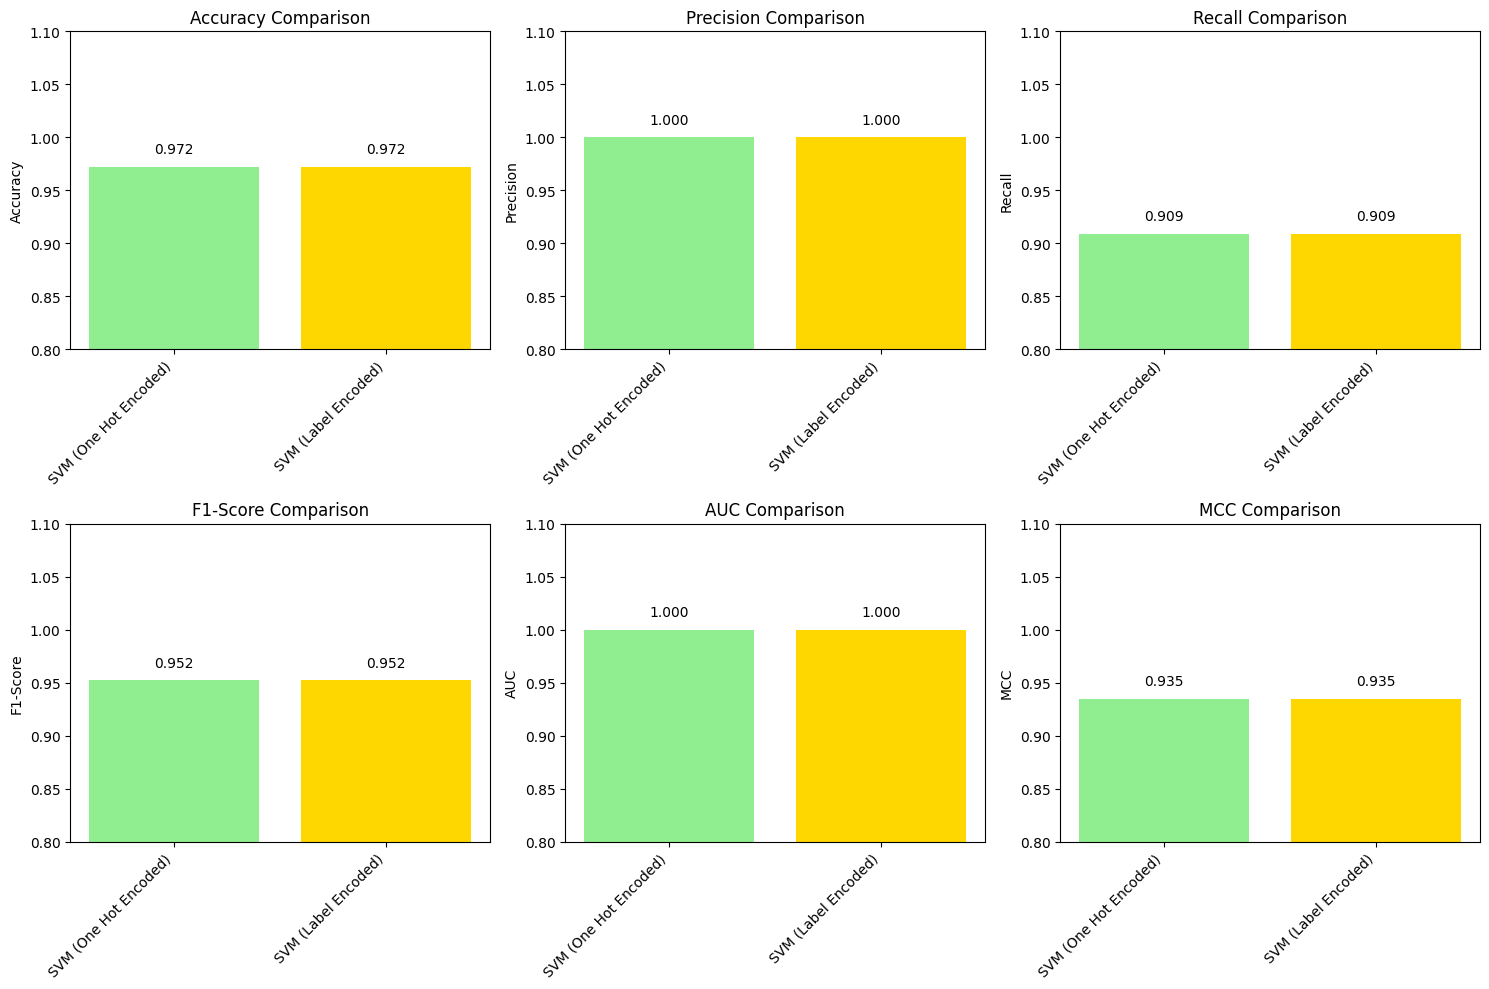

In [56]:
# Add the SVM Label Encoded metrics to the performance comparison


performance_data_updated = {
    'Model': ['SVM (One Hot Encoded)', 'SVM (Label Encoded)'],
    'AUC': [auc_af_svm, svm_le_auc],
    'MCC': [mcc_af_svm, svm_le_mcc]
}

# Create updated DataFrame
performance_df_updated = pd.DataFrame(performance_data_updated)

# Add the SVM Label Encoded metrics to additional metrics
additional_metrics_updated = [
    {
        'Model': 'SVM (One Hot Encoded)',
        'Accuracy': accuracy_score(y_test_af, y_pred_af_svm),
        'Precision': precision_score(y_test_af, y_pred_af_svm),
        'Recall': recall_score(y_test_af, y_pred_af_svm),
        'F1-Score': f1_score(y_test_af, y_pred_af_svm)
    },
    {
        'Model': 'SVM (Label Encoded)',
        'Accuracy': svm_le_accuracy,
        'Precision': svm_le_precision,
        'Recall': svm_le_recall,
        'F1-Score': svm_le_f1
    }
]

additional_df_updated = pd.DataFrame(additional_metrics_updated)

# Merge the dataframes
final_performance_df_updated = pd.merge(performance_df_updated, additional_df_updated, on='Model')

# Create a visual comparison with updated data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'MCC']
colors = ['lightgreen', 'gold']

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    bars = ax.bar(final_performance_df_updated['Model'], final_performance_df_updated[metric], color=colors)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_ylim(0.8, 1.1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(final_performance_df_updated['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [57]:
# Not noticing any performance differences? Small dataset?

# Managed to find a new dataset to play with (14 columns, 1000+ rows) (heart.csv)